In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import types
import pickle
import random
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches

pd.options.mode.chained_assignment = None

# Importing & Preparing Data

In [3]:
PATH = 'data/co-authorship-network/'

In [4]:
edges = pd.read_table(PATH + '/edges.txt', sep=',', header=None)
edges.columns = ["source", "target"]
edges_original = edges.copy()

In [5]:
# Construct graph from edgelist & truncate the graph and cat_df
cat_df = pd.read_csv("Categorical_DF_majority_discipline.csv").set_index('Node ID')
G = nx.from_pandas_edgelist(edges)
G = G.subgraph(cat_df.index)

In [6]:
for node_id, discipline in cat_df['Discipline'].iteritems():
    G.nodes[node_id]['Discipline'] = discipline

# Finding Largest Connected Component

In [7]:
# Define a BFS function that returns the connected component and stops when the size limit is reached
def bfs_connected_component(graph, start_node, size_limit):
    visited = set()
    queue = [start_node]

    while queue:
        node = queue.pop(0)
        if node not in visited:
            visited.add(node)
            if len(visited) >= size_limit:
                break
            neighbors = list(graph.neighbors(node))
            queue.extend(neighbors)

    return visited

def get_random_cc_with_categories(size_limit, G=G, min_percentage=0.3):
    connected_component = set()
    while True:
        # Pick a random node and perform BFS until you find a connected component w/size limit
        random_node = random.choice(list(G.nodes()))
        connected_component = bfs_connected_component(G, random_node, size_limit)

        # Create a subgraph of the connected component
        G_cc = G.subgraph(connected_component)

        # Count the number of nodes for each category in the connected component
        cat_counts = cat_df[cat_df.index.isin(G_cc.nodes())]['Discipline'].value_counts()
        cat_percentages = cat_counts / len(connected_component)

        # Check if at least two categories have more than min_percentage nodes
        if (cat_percentages >= min_percentage).sum() >= 2:
            # print(str(cat_percentages) + "\n---------------------")
            return connected_component               

In [8]:
def draw_graph(G, cat_df=cat_df, draw_func=None):
    # Get the values of the category
    cat_values = cat_df[cat_df.index.isin(G.nodes)]['Discipline'].unique()
    colors = [plt.cm.Set2(i/float(len(cat_values)-1)) for i in range(len(cat_values))]

    # Create a dictionary mapping category values to colors & map nodes to colors
    value_to_color = dict(zip(cat_values, colors))
    node_colors = [value_to_color[cat_df.loc[n]['Discipline']] for n in G.nodes()]

    # Draw the graph
    plt.figure(figsize=(5, 5))
    nx.draw(G, node_size=25, node_color=node_colors)

    # Create a patch for each category value
    patches = [plt.plot([],[], marker="o", color=colors[i], 
               label="{}".format(cat_values[i]))[0] for i in range(len(cat_values))]

    # Add legend
    plt.legend(handles=patches);
    
def draw_cat_distribution(G, cat_df=cat_df):
    cat_df_subset = cat_df[cat_df.index.isin(G.nodes)]
    cat_df_subset.Discipline = cat_df_subset.Discipline.cat.remove_unused_categories()
    cat_df_subset['Discipline'].value_counts().plot(kind='bar');

In [9]:
# random_cc = get_random_cc_with_categories(500)
# G_cc = G.subgraph(random_cc)
# draw_graph(G_cc)

# Finding Subgraphs with Community Structure

In [10]:
def save_obj(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)

def load_obj(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)
    
def save_graph_image(G, clusters, cat_df, filename):
    fig, ax = plt.subplots(figsize=(20, 20))
    draw_graph(G)
    plt.savefig(filename, dpi=300)
    plt.close(fig)

In [14]:
def get_random_cc_with_clusters_bfs(size_limit, G=G, min_percentage=0.3, in_group_threshold=0.8):
    connected_component = set()
    while True:
        # Pick a random node and perform BFS until you find a connected component w/size limit
        random_node = random.choice(list(G.nodes()))
        connected_component = bfs_connected_component(G, random_node, size_limit)

        # Create a subgraph of the connected component
        G_cc = G.subgraph(connected_component)

        # Calculate in-group and out-group degrees for each node in the connected component
        in_group_degrees = []
        out_group_degrees = []
        for node in G_cc.nodes():
            neighbors = list(G_cc.neighbors(node))
            discipline = cat_df.loc[node]['Discipline']
            in_group_degree = sum([1 for neighbor in neighbors if cat_df.loc[neighbor]['Discipline'] == discipline])
            out_group_degree = len(neighbors) - in_group_degree
            in_group_degrees.append(in_group_degree)
            out_group_degrees.append(out_group_degree)

        # Check if the majority of nodes have a high in-group degree and a low out-group degree
        in_group_ratio = np.array(in_group_degrees) / (np.array(in_group_degrees) + np.array(out_group_degrees))
        high_in_group_nodes = (in_group_ratio >= in_group_threshold).sum()
        if high_in_group_nodes / len(connected_component) >= min_percentage:
            return connected_component
        print("Need to try another connected component...")

In [15]:
def get_random_cc_with_clusters_random_walk(size_limit, G=G, min_percentage=0.3, num_walks=10, walk_length=100):
    connected_component = set()
    while True:
        # Perform random walks from a randomly chosen node
        random_node = random.choice(list(G.nodes()))
        discipline_counts = {discipline: 0 for discipline in cat_df['Discipline'].unique()}
        for _ in range(num_walks):
            current_node = random_node
            visited_nodes = set([current_node])
            for _ in range(walk_length):
                neighbors = list(G.neighbors(current_node))
                unvisited_neighbors = [neighbor for neighbor in neighbors if neighbor not in visited_nodes]
                if not unvisited_neighbors:
                    break
                next_node = random.choice(unvisited_neighbors)
                discipline_counts[cat_df.loc[next_node]['Discipline']] += 1
                visited_nodes.add(next_node)
                current_node = next_node

        # Check if the difference between the number of visits to each discipline is small
        discipline_counts = np.array(list(discipline_counts.values()))
        discipline_ratios = discipline_counts / discipline_counts.sum()
        if np.abs(discipline_ratios[0] - discipline_ratios[1]) <= min_percentage:
            connected_component = bfs_connected_component(G, random_node, size_limit)
            return connected_component

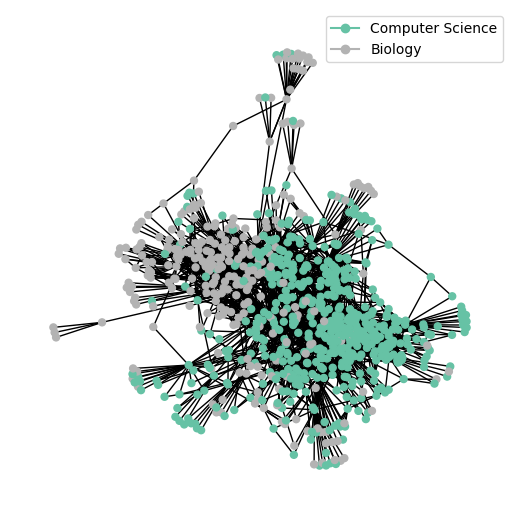

In [17]:
cc_bfs = get_random_cc_with_clusters_bfs(800)
G_cc_bfs = G.subgraph(cc_bfs)
draw_graph(G_cc_bfs)

In [ ]:
cc_random_walk = get_random_cc_with_clusters_random_walk
G_cc_random_walk = G.subgraph(cc_random_walk)
draw_graph(G_cc_random_walk)

# Plotting in-group degree vs. out-group degrees

In [49]:
def plot_group_degrees(G_cc):
    # Get the category DataFrame for the connected component
    cat_df_cc = cat_df[cat_df.index.isin(G_cc.nodes())]

    # Get the unique category values
    cat_values = cat_df_cc['Discipline'].unique()

    # Separate nodes in the connected component into groups based on their Discipline value
    nodes_groups = {value: [n for n in G_cc.nodes() if cat_df_cc.loc[n]['Discipline'] == value] for value in cat_values}

    # Filter nodes_groups to exclude categories with no nodes
    nodes_groups_filtered = {value: nodes for value, nodes in nodes_groups.items() if len(nodes) > 0}
    filtered_cat_values = list(nodes_groups_filtered.keys())

    # Calculate in-group and out-group degrees for each group with nodes
    group_degrees = {}
    for value, nodes in nodes_groups_filtered.items():
        in_group_degrees, out_group_degrees = [], []
        for node in nodes:
            other_groups = [nodes_groups_filtered[other_value] for other_value in filtered_cat_values if other_value != value]
            other_nodes = [item for sublist in other_groups for item in sublist]
            connections_in_group, connections_out_group = get_node_degrees(node, G_cc, nodes, other_nodes)
            in_group_degrees.append(connections_in_group)
            out_group_degrees.append(connections_out_group)
        group_degrees[value] = (in_group_degrees, out_group_degrees)

    # Plot histograms of in-group and out-group degrees for groups with nodes
    fig, axs = plt.subplots(len(filtered_cat_values), 2, figsize=(10, 5 * len(filtered_cat_values)))
    max_bin_width = 1

    for i, value in enumerate(filtered_cat_values):
        # Calculate the range of in-group and out-group degrees
        in_group_range = np.ptp(group_degrees[value][0])
        out_group_range = np.ptp(group_degrees[value][1])

        # Calculate the number of bins, making sure the bin width doesn't go below max_bin_width
        in_group_bins = max(int(in_group_range / max_bin_width), 1)
        out_group_bins = max(int(out_group_range / max_bin_width), 1)

        # In-group degree histogram for the current group
        axs[i, 0].hist(group_degrees[value][0], bins=in_group_bins, density=True)
        axs[i, 0].set_xlabel('In-group degree')
        axs[i, 0].set_ylabel('Proportion of nodes')
        axs[i, 0].set_title(f'In-group Degree Histogram for {value}')
    
        # Out-group degree histogram for the current group
        axs[i, 1].hist(group_degrees[value][1], bins=out_group_bins, density=True)
        axs[i, 1].set_xlabel('Out-group degree')
        axs[i, 1].set_ylabel('Proportion of nodes')
        axs[i, 1].set_title(f'Out-group Degree Histogram for {value}')

    plt.subplots_adjust(top=0.9, hspace=0.4)

In [55]:
# plot_group_degrees(G_cc)